# Classification /extraction 
--- 

we should consider only some properties derivated  from items but in this case we can build a vocabulary of property initially for two categories **Culture Representative** and **Culture Agnostic**. 


### How should we chose properties from item of Culture Agnostic and Culture Representative? 
### Training  Phase:

--- 

### Step 1: Building 1 vocabulary of properties associated to Culture Representative and Culture Agnostic 
In this phase, for every sample $ item_{i} $ associated to, we put all its properties  into a set  $S_{P} $
### Step 2: Embedded vectors of properties for every item 
In this case we associate a binary vector for every $item_{i} $ where for every possible property we associate 1 if it has that property $P_k$ otherwise 0.
### Step 3: Compute the centroids for every category C.A C.R, C.E.X
Now, after the preprocessed data we compute the centroid (like mean over every property $P_k$ on all samples) $C_{CA} $ and $C_{CR} $.
### Step 4: We compute the euclidean distance among properties and centroids
for every sample we compute distance among each property and centroids, so we will interpret strong relationship of some  properties wrt culture concepts while for concept more neutrals
### Step 5: Corresponding the similarity to every property with some methods wrt centroids
Every property, will have a weight computed following the importance of distance wrt centroids $C_{C.A} $ and  $ C_{C.R}$ : 
#### Case 1: Kernel Funtion (Kernel Density Estimation)
we will use kernel to give a more flexible weight : $ w_{gauss}(item_{i})=\exp{(-\frac{d_{C}(item_{i})}{2*\sigma^2})} $ .
We can compute **$\sigma$** like a constant such that influences the area of neighbours entities: 
we can compute it as: $\sigma=\frac{1}{\sqrt{2}*mean \space of \space distance}$, can be optimized empirically 
**The Gaussian kernel has the advantage of providing a gradual decrease in weight rather than a linear or inversely proportional decrease, allowing us to assign greater weight to nearby entities without excluding those that are further away.** .
We normalize all weights wrt the sum following weights wrt centroids

### Test Phase:

### Step 1: Compute distance among every element wrt to the both centroids
we compute per every $item_i$  and every feature of kind: $P_{123},P_{2345} $ ecc... the euclidean distance
### Step 2: Compute similarity for every test sample(with kernel approach) for both centroids
this pass helps us to understand in which direction a sample should go to the centroids for both centroids 
### Step 3: Given averaged sum of the importance of feature of samples 
in this step we compute, Culture and Agnostic_score= $ \sum_{fi=1}^{N_feat} item_{fi}* importance \space of  \space features $  the secnond term is measured in previous case
### Step 4 : Then, to emphasize the influence of entities closer to the centroids, we multiply the weighted score by the similarity.
So, ultimately, we multiply the weighted score by similarity to get a total score that is more sensitive to the entity's proximity to the centroids. This helps make a more accurate prediction based on how much the entity resembles the cultural or agnostic centers.

total_culture_score=$ Culture \space and  \space Agnostic_score * similarity \space of \space distance \space of \space test_sample $ repeated for every class score
total_agnostic_score = ... 
### Step 5: Classification based on best result
if total_culture_score > total agnostic_score  -> **Culture Representative**









# Step 0: Building a Vocabulary with all properties of training items

In [2]:
from datasets import load_dataset
import pandas as pd
import torch as t 
import numpy as np
import matplotlib.pyplot as plt
from wikidata.client import Client
from itertools import islice
from collections import Counter,defaultdict
from concurrent.futures import ThreadPoolExecutor
from scipy.spatial.distance import euclidean
from statistics import mean, stdev
import urllib.error
import json
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,accuracy_score

In [3]:
ds=load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")

train_set=train_data=pd.DataFrame(ds["train"])
test_set=train_data=pd.DataFrame(ds["validation"])
list_category=set(list(train_set.category))
print(list_category)
list_subcategory=set(list(train_set.subcategory))
X_train=train_set.values
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(X_train) # stamp all dataset
#print(X_train.shape) 
validation_set=pd.DataFrame(ds["validation"])
X_valid=validation_set.values
print(X_valid)

{'performing arts', 'films', 'transportation', 'geography', 'history', 'biology', 'philosophy and religion', 'media', 'books', 'visual arts', 'sports', 'music', 'gestures and habits', 'food', 'politics', 'literature', 'architecture', 'comics and anime', 'fashion'}
[['http://www.wikidata.org/entity/Q32786' '916' '2012 film by M. Mohanan'
  ... 'films' 'film' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q371' '!!!'
  'American dance-punk band from California' ... 'music' 'musical group'
  'cultural representative']
 ['http://www.wikidata.org/entity/Q3729947' '¡Soborno!'
  'Mort & Phil comic' ... 'comics and anime' 'comics'
  'cultural representative']
 ...
 ['http://www.wikidata.org/entity/Q10779' 'Zwenkau'
  'city in the district of Leipzig, in the Free State of Saxony, Germany'
  ... 'geography' 'city' 'cultural exclusive']
 ['http://www.wikidata.org/entity/Q245296' 'zydeco'
  'music genre evolved in southwest Louisiana which blends blues, rhythm and blues, and music indigen

In [4]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]
#print(X_train.shape[0])
def extract_sample_from_cat(X,cat):
    l=list()
    for elem in X:
        if elem[4]==cat:
            l.append(elem[0])
    return np.array(l)
client = Client()

In [15]:

vocabulary=list()
def build_vocabulary(cat):
    vocabulary_subset=list()
    list_sample_cat=extract_sample_from_cat(X_train,cat)
    number_list_sample_cat=len(list_sample_cat)
    #print("sample category: "+cat)
    #print(len(list_sample_cat))
    set_properties=list()
    #set_properties=np.array(set_properties)
    for url in list_sample_cat:
        entity_train=extract_entity_id(url)
        #-----Check on entity train
        if not entity_train or not entity_train.startswith("Q"): #verify if entity_id starts with Q
            continue
        try:
            item = client.get(entity_train, load=True)
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            continue
        #------
        claim_item_i=item.data.get("claims",{})
       # print(claim_item_i)
        #print(len(claim_item_i))
        set_property_item=set()
        for prop_id,values in islice(claim_item_i.items(),len(claim_item_i)):
            #prop_entity = client.get(prop_id, load=True)
            #label = prop_entity.label
            #print(f"{prop_id} = {label} ({len(values)} statement{'s' if len(values) != 1 else ''})")
            set_property_item.add(str(prop_id))
        set_properties.append(set_property_item)

    print("Category:"+cat+" collected")




    property_presence_sample=defaultdict(list) #dizionario in cui ogni key è una property e value=[1,0,0,1] lunga quanto numero di sample con 1=se propid appartiene a quel sample
    all_props = set().union(*set_properties)  # insieme di tutte le proprietà presenti nei sample
    for prop in all_props:
        for prop_set in set_properties:
            # append 1 se la proprietà è presente nel sample, altrimenti 0
            property_presence_sample[prop].append(1 if prop in prop_set else 0)
    
    filtered_props = []

    for prop, values in property_presence_sample.items():
        prop_mean = mean(values)
        if len(values) > 1:
            prop_std = stdev(values)  
        else:
            prop_std=0
        #if prop_mean >= 0.5:
        filtered_props.append((prop, prop_mean, prop_std))
    #print(f"tuple props (prop,mean,std) {filtered_props}")

    counter=Counter()
    for s in set_properties:
        counter.update(s)
        #for prop in s:
         #   counter[prop]+=1
    #frequency_prop=counter
    #frequency_prop=count_frequency_prop_id(set_properties)
    #sorted_prop=frequency_prop.most_common()
   # print(sorted_prop)
    #threshold=int(len(sorted_prop)*0.6)
    # ERROR
    prop_counts = list(counter.values())
   # print(f"Counts prop {prop_counts}")
    #------
    #mu=mean(prop_counts)
    #if len(prop_counts)> 1:
    #    dev_std=stdev(prop_counts)
    #else:
      #  dev_std=0
    #print(f"mean : {mu} and std_dev {dev_std}")
    #th=0.2
    #if(number_list_sample_cat>=429):
    #    th=0.35
    #elif number_list_sample_cat>=300:
    #    th=0.4
    #elif number_list_sample_cat>=150:
     #   th=0.45
    #th=dynamic_threshold(number_list_sample_cat)
    #for prop_i,count in sorted_prop:
      #  support_categories=count/number_list_sample_cat
      #  if support_categories>=th: #min support 
      #      vocabulary_subset.append(prop_i)
        #if len(vocabulary_subset)>=6: #the first top k
            #break
    #print("Updated Vocabulary",vocabulary_subset) 
    #-----  
   # coeff_var = dev_std / mu if mu > 0 else 0.0
    #z_th = 1.0 + 0.5* coeff_var
    #z_th = min(max(z_th, 1.0),2.0)
    #print(f"threshold category {cat}: {z_th}")
    z_th=4.0
    #for prop_id,count in counter.items():
    for prop_id,mu_prop,dev_s_prop in filtered_props:
        #coeff_var = dev_s_prop / mu_prop if mu_prop > 0 else 0.0
        #z_th = 1.0 + 0.5* coeff_var
        #z_th = min(max(z_th, 1.0),2.0)
        z_score=(counter.get(prop_id)-mu_prop)/dev_s_prop # apply zscore
        if z_score>=z_th:
            vocabulary_subset.append(prop_id)
    print(f"Vocabulary {cat}: {vocabulary_subset}")       
    return vocabulary_subset
        #set_property_item.clear()
    #print("intersection of sample belongs"+cat,set.intersection(*set_properties))

        #label = prop_entity.labels
        #print(claim_item_i)


### Execute for category

In [16]:
with  ThreadPoolExecutor(max_workers=10) as executor:
    results=list(executor.map(build_vocabulary,list_category))

for vocab in results:
    vocabulary.extend(vocab)
vocabulary=list(set(vocabulary))
print("Updated Vocabulary: for categories",vocabulary)
with open("vocabulary_category.json", "w") as f:
    json.dump(vocabulary, f)
#Updated Vocabulary: for categories previous case["P106", "P569", "P227", "P6366", "P646", "P373", "P18", "P495", "P641", "P279", "P19", "P244", "P1566", "P159", "P214", "P31", "P27", "P571", "P345", "P17", "P625", "P21", "P131", "P910", "P8189", "P856"]

Category:books collected
Vocabulary books: ['P2001', 'P486', 'P1149', 'P4839', 'P8013', 'P11182', 'P1273', 'P1942', 'P2088', 'P1320', 'P12582', 'P3987', 'P2397', 'P103', 'P345', 'P291', 'P3215', 'P1442', 'P1104', 'P8947', 'P10111', 'P1315', 'P734', 'P2521', 'P8253', 'P154', 'P6412', 'P6722', 'P1004', 'P3430', 'P21', 'P2031', 'P6155', 'P7772', 'P1424', 'P1411', 'P4629', 'P3095', 'P2604', 'P3602', 'P9881', 'P373', 'P2734', 'P1375', 'P12458', 'P921', 'P10013', 'P1006', 'P13183', 'P12086', 'P625', 'P767', 'P3368', 'P3032', 'P1430', 'P9775', 'P463', 'P4357', 'P149', 'P1454', 'P4235', 'P1449', 'P1661', 'P1709', 'P6821', 'P12782', 'P11947', 'P9100', 'P6366', 'P7293', 'P740', 'P649', 'P425', 'P1071', 'P7837', 'P1705', 'P159', 'P2561', 'P281', 'P2850', 'P11514', 'P7959', 'P10151', 'P2354', 'P953', 'P6178', 'P6275', 'P1766', 'P268', 'P1015', 'P1556', 'P701', 'P3280', 'P13019', 'P9495', 'P512', 'P8603', 'P856', 'P571', 'P7445', 'P355', 'P279', 'P110', 'P8851', 'P5463', 'P9037', 'P650', 'P1616', '

4308


### Execute for subcategory

In [ ]:
with  ThreadPoolExecutor(max_workers=10) as executor:
    results=list(executor.map(build_vocabulary,list_subcategory))
vocabulary_subc=list()
for vocab in results:
    vocabulary_subc.extend(vocab)
vocabulary_subc=list(set(vocabulary_subc))
print("Updated Vocabulary: for categories",vocabulary_subc)
#Updated Vocabulary: for categories ['P495', 'P279', 'P345', 'P910', 'P17', 'P571', 'P373', 'P18', 'P625', 'P856', 'P244', 'P646', 'P31', 'P131', 'P641']

Category:actor collected
tuple props (prop,mean,std) []
Vocabulary actor: []
Category:bookstore collected
tuple props (prop,mean,std) []
Vocabulary bookstore: []
Category:historical event collected
tuple props (prop,mean,std) []
Vocabulary historical event: []
Category:government agency collected
tuple props (prop,mean,std) []
Vocabulary government agency: []
Category:model collected
tuple props (prop,mean,std) []
Vocabulary model: []
Category:law collected
tuple props (prop,mean,std) []
Vocabulary law: []
Category:comics artist collected
tuple props (prop,mean,std) []
Vocabulary comics artist: []
Category:transport company collected
tuple props (prop,mean,std) []
Vocabulary transport company: []
Category:ritual collected
tuple props (prop,mean,std) []
Vocabulary ritual: []
Category:mountain collected
tuple props (prop,mean,std) []
Vocabulary mountain: []
Category:policy collected
tuple props (prop,mean,std) []
Vocabulary policy: []
Category:literary award collected
tuple props (prop,m

# Step 1: Embedding con vettori binari 1/0 

In [ ]:
 

from scipy.spatial.distance import euclidean
from sklearn.feature_selection import mutual_info_classif

def weight_property(X,Y):
    mi_result=mutual_info_classif(X, Y,discrete_features=True)
    print(f"MI result {mi_result}")
    weighted_mi_result=mi_result/np.sum(mi_result)
    print(f"MI result{weighted_mi_result}")
    return weighted_mi_result

def weight_distance_estimation(X1,X2,w):
   
    dist=np.sqrt(np.sum((X1 - X2)**2))
    weights=1/(dist+1e-8)
    return weights
def extract_dictionary_property(X):
    d=dict()
    for i in range(0,X.shape[0]):
        item=client.get(extract_entity_id(X[i,0]),load=True)
        claim_item_i=item.data.get("claims",{})
        set_p=set()
        for prop_id,__ in islice(claim_item_i.items(),len(claim_item_i)):
            set_p.add(str(prop_id))
        d[i]=set_pz
        print(f"sample {i} processed")
    return d
# too slow :( try parallelization
#----------
def embedding_sample(X,vocabulary):
    X_train_emb=np.zeros((X.shape[0],len(vocabulary)),dtype=np.int32)
   # X_train_emb=np.zeros(shape=(X.shape[0],len(vocabulary)))
    #print(f"Processing {X.shape[0]} sample")
    def process_sample(j):
        ent=extract_entity_id(X[j,0])
        if not ent or not ent.startswith("Q"): #verify if entity_id starts with Q
            return j,None
        try:
            item= client.get(ent, load=True)
            #print(f"item raccolte sample {j}")
        except urllib.error.HTTPError: #handle error of HTTP error like HTTP 404
            return j,None
        item_j = client.get(ent, load=True)
        claim_item_i=item.data.get("claims",{})
        #print("processed:",claim_item_i)
        set_p=set()
        for prop_id,__ in islice(claim_item_i.items(),len(claim_item_i)):
            set_p.add(str(prop_id))
        sample=np.zeros(len(vocabulary),dtype=np.int32)
        for v in range(0,len(vocabulary)):
            if vocabulary[v] in set_p:
                sample[v]=1
        print(f"embedded sample {j,sample}")
        return j,sample
        #np.arange(X_train_emb=X[j,6]
        #print(f"Update X_train_emb {j}: {X_train_emb[j]}")
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = executor.map(process_sample, range(X.shape[0]))
    for i,sample_embedded in results:
        if sample_embedded is not None:
            X_train_emb[i]=sample_embedded
    return X_train_emb

In [19]:
with open("vocabulary_category.json","r",encoding="utf-8") as f:
    vocabulary_j=json.load(f)
print(vocabulary_j)
print(len(vocabulary_j))

['P4200', 'P827', 'P2944', 'P10417', 'P11182', 'P8580', 'P6266', 'P1270', 'P11800', 'P457', 'P61', 'P467', 'P7300', 'P3408', 'P806', 'P10242', 'P12439', 'P3513', 'P3987', 'P9975', 'P103', 'P2366', 'P3411', 'P169', 'P2789', 'P3407', 'P9328', 'P863', 'P10807', 'P9864', 'P8116', 'P12483', 'P1442', 'P4272', 'P4660', 'P8368', 'P10111', 'P2521', 'P11936', 'P5786', 'P4263', 'P6300', 'P2006', 'P1900', 'P6722', 'P11386', 'P5891', 'P634', 'P3430', 'P8674', 'P9368', 'P1300', 'P7772', 'P12631', 'P11827', 'P2943', 'P8119', 'P840', 'P3919', 'P8138', 'P10874', 'P3330', 'P1330', 'P809', 'P4644', 'P4791', 'P1192', 'P1947', 'P4014', 'P6714', 'P6933', 'P10013', 'P5068', 'P7311', 'P6954', 'P1333', 'P4772', 'P10757', 'P8361', 'P4158', 'P3368', 'P2923', 'P1430', 'P7285', 'P5343', 'P4357', 'P3711', 'P8887', 'P2783', 'P10243', 'P5492', 'P1639', 'P8516', 'P11961', 'P1034', 'P2438', 'P2889', 'P7997', 'P9321', 'P7819', 'P2566', 'P272', 'P7796', 'P10480', 'P3284', 'P2849', 'P9080', 'P12782', 'P1438', 'P2675', 'P1

In [20]:
print("Embedding culture representative samples")
culture_representative_train=embedding_sample(X_train[X_train[:,6]=='cultural representative'],vocabulary_j)


Embedding culture representative samples
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (13, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (10, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (16, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (18, array([0, 0, 0, ..., 0, 

In [22]:
print("--Embedding culture agnostic sample")
culture_agnostic_train=embedding_sample(X_train[X_train[:,6]=='cultural agnostic'],vocabulary_j)

--Embedding culture agnostic sample
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (6, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (13, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (14, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (12, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (10, array([0, 0, 0, ..., 0, 0, 0]

In [28]:
print("--Embedding Culture exclusive sample")
culture_exclusive_train=embedding_sample(X_train[X_train[:,6]=='cultural exclusive'],vocabulary_j)

--Embedding Culture exclusive sample
embedded sample (6, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (3, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (1, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (5, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (0, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (4, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (7, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (2, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (9, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (8, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (10, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (14, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (12, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (15, array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
embedded sample (11, array([0, 0, 0, ..., 0, 0, 0

In [29]:
# insert of binary vectors
#------------
#X_embed_train=embedding_sample(X_train,vocabulary)

#set_properties_train_sample=extract_dictionary_property(X_train)



print(f"culture_agnostic_train: {culture_agnostic_train}")
print(f"cutlure agnostic shape {culture_agnostic_train.shape}")

print(f"culture_representative_train {culture_representative_train}")
print(f"culture_representative_train shape {culture_representative_train.shape}")

print(f"culture_exlusive_train {culture_exclusive_train}")
print(f"culture_exlusive_train shape {culture_exclusive_train.shape}")

np.savez("train_sample_embeddings.npz",representative=culture_representative_train,agnostic=culture_agnostic_train,exclusive=culture_exclusive_train)


culture_agnostic_train: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
cutlure agnostic shape (1872, 4311)
culture_representative_train [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
culture_representative_train shape (1688, 4311)
culture_exlusive_train [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
culture_exlusive_train shape (2691, 4311)


In [30]:
def numerical_label(Y):
    Y_index=np.zeros(Y.shape[0],dtype=np.int32)
    for i in range(0,Y.shape[0]):
        if Y[i]=="cultural agnostic":
            Y_index[i]=0
        elif Y[i]=="cultural representative":
            Y_index[i]=1
        else:
            Y_index[i]=2
    return Y_index
def binary_label(Y,label):
    return (Y==label).astype(int)

In [ ]:
def weight_sample(X,W):
    if X.ndim==2:
        for i in range(0,X.shape[0]):
            for j in range(0,X.shape[1]):
                X[i,j]*=W[j]
    else:
        for i in range(0,X.shape[0]):
            X[i]*=W[i]
    return X

In [31]:
train_embedded=np.load("train_sample_embeddings.npz")



all_train_sample=np.concatenate((train_embedded["agnostic"],train_embedded["representative"],train_embedded["exclusive"]),axis=0)

weights_properties_MI_agnostic=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural agnostic"))
weights_properties_MI_representative=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural representative"))
weights_properties_MI_exclusive=weight_property(all_train_sample,binary_label(X_train[0:,6],"cultural exclusive"))

print(f"weight_property MI Agnostic {weights_properties_MI_agnostic}")
print(f"weights_property MI representative {weights_properties_MI_representative}")
print(f"weights_properties MI exclusive {weights_properties_MI_exclusive}")

centroid_agnostic=np.mean(train_embedded["agnostic"],axis=0)
print(f"centroid agnostic for each property {centroid_agnostic.shape}",centroid_agnostic)
centroid_representative=np.mean(train_embedded["representative"],axis=0)
print(f"centroid_representative {centroid_representative.shape}",centroid_representative)
centroid_exclusive=np.mean(train_embedded["exclusive"],axis=0)
print(f"centroid_exclusive {centroid_exclusive.shape}",centroid_exclusive)


np.savez("weights_properties_MI.npz",weights_properties_CA=weights_properties_MI_agnostic,weights_properties_CR=weights_properties_MI_representative,weights_properties_CE=weights_properties_MI_exclusive)
np.savez("centroids_every_label.npz",centroid_CA=centroid_agnostic,centroid_CR=centroid_representative,centroid_CE=centroid_exclusive)

#---



X_valid_embed=embedding_sample(X_valid,vocabulary_j)
np.savez("X_valid_embedded.npz",validation_embedded=X_valid_embed)





MI result [2.53057974e-07 1.46330322e-04 1.13898406e-04 ... 5.69437309e-05
 1.70864031e-04 5.69437309e-05]
MI result[6.66537532e-07 3.85424138e-04 3.00000674e-04 ... 1.49985923e-04
 4.50044263e-04 1.49985923e-04]
MI result [3.76095004e-05 2.59967987e-04 1.00726394e-04 ... 5.03584615e-05
 4.66989076e-06 2.09472617e-04]
MI result[9.65565749e-05 6.67427595e-04 2.58599436e-04 ... 1.29287560e-04
 1.19892222e-05 5.37788544e-04]
MI result [2.45437260e-05 2.84743993e-05 2.69729736e-04 ... 1.34847931e-04
 5.42728243e-05 9.00722088e-05]
MI result[6.20907529e-05 7.20345755e-05 6.82362667e-04 ... 3.41138486e-04
 1.37299468e-04 2.27864801e-04]
weight_property MI Agnostic [6.66537532e-07 3.85424138e-04 3.00000674e-04 ... 1.49985923e-04
 4.50044263e-04 1.49985923e-04]
weights_property MI representative [9.65565749e-05 6.67427595e-04 2.58599436e-04 ... 1.29287560e-04
 1.19892222e-05 5.37788544e-04]
weights_properties MI exclusive [6.20907529e-05 7.20345755e-05 6.82362667e-04 ... 3.41138486e-04
 1.3729

In [34]:
def predict_entity_score(x_sample,centroid_CA,centroid_CR,centroid_CE,weights_CA,weights_CR,weights_CE):  
    similiraty_sample_CA=weight_distance_estimation(x_sample,centroid_CA,weights_CA)
    similarity_sample_CR=weight_distance_estimation(x_sample,centroid_CR,weights_CR)
    similarity_sample_CE=weight_distance_estimation(x_sample,centroid_CE,weights_CE)
    print(f"similarity_sample_CA {similiraty_sample_CA}")
    print(f"similarity_sample_CR {similarity_sample_CR}")
    print(f"similarity_sample_CE {similarity_sample_CE}")
 
    Sum_score_CA=0
    Sum_score_CR=0
    Sum_score_CE=0
    #f
    for i in range(0,x_sample.shape[0]):
      Sum_score_CA+=x_sample[i]*weights_CA[i]
      Sum_score_CR+=x_sample[i]*weights_CR[i]
      Sum_score_CE+=x_sample[i]*weights_CE[i]
    l=0.9
    mean_score=(Sum_score_CA+Sum_score_CR+Sum_score_CE)/3
    total_score_agnostic=mean_score*similiraty_sample_CA
    total_score_representative=mean_score*similarity_sample_CR
    total_score_exclusive=mean_score*similarity_sample_CE
    print(f"total_score_agnostic {total_score_agnostic}")
    print(f"total_score_representative {total_score_representative}")
    print(f"total_score_exclusive {total_score_exclusive}")
    return np.argmax([total_score_agnostic,total_score_representative,total_score_exclusive])

[1 2 1 2 1 2 1 2 1 1 0 0 0 1 1 1 1 1 0 1 2 1 1 0 2 0 0 0 0 0 0 2 2 1 1 2 2
 2 1 1 2 0 0 1 0 1 2 1 1 1 0 0 1 1 0 2 1 2 2 2 0 0 2 2 2 0 0 0 0 0 0 0 0 1
 0 1 2 0 1 1 2 0 1 1 2 0 2 0 2 0 2 0 1 2 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 2 2
 1 0 1 0 1 1 1 1 0 0 0 0 1 1 2 1 2 1 1 1 2 2 0 0 1 1 2 0 0 1 1 1 1 1 2 2 0
 2 1 1 2 2 0 2 0 1 0 1 1 0 1 2 0 0 0 2 1 2 1 2 1 0 2 1 2 2 1 0 0 2 0 1 0 1
 0 1 1 2 0 2 1 0 2 0 1 1 2 1 2 1 0 0 1 0 1 1 1 1 2 0 0 0 0 2 0 1 0 0 1 1 0
 0 2 0 0 0 2 1 0 2 2 2 2 2 2 2 0 0 1 2 1 1 0 0 2 1 2 0 1 2 1 0 0 0 0 0 2 1
 1 2 1 2 0 0 1 1 0 2 2 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 2 0 0 0
 1 2 1 2]
similarity_sample_CA 0.1602233245041245
similarity_sample_CR 0.16299554744617473
similarity_sample_CE 0.16820879228974905
total_score_agnostic 0.0015262499746199207
total_score_representative 0.001552657523009269
total_score_exclusive 0.001602317676016442
2
similarity_sample_CA 0.27317649283169904
similarity_sample_CR 0.25402860858399734
similarity_sample_CE 0.3005289616276049
total_scor

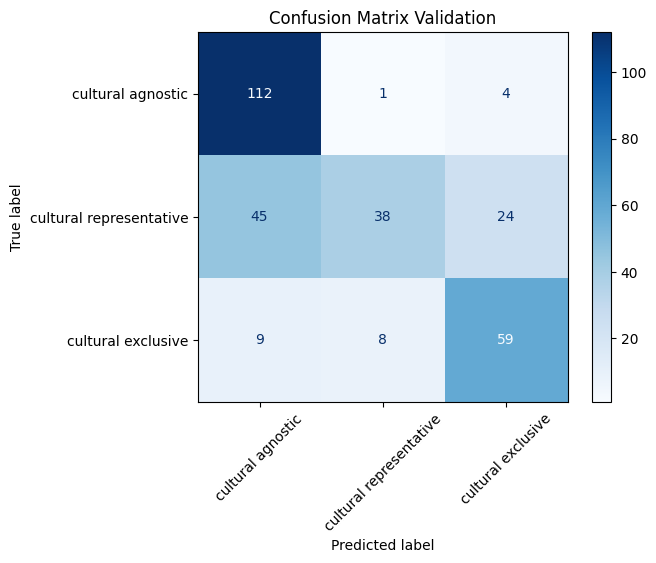

In [35]:
train_embedded=np.load("train_sample_embeddings.npz")
centroids=np.load("centroids_every_label.npz")
weights=np.load("weights_properties_MI.npz")
valid_embedded=np.load("X_valid_embedded.npz")
X_valid_emb=valid_embedded["validation_embedded"]
Y_true_valid=numerical_label(X_valid[0:,6])
print(Y_true_valid)
Y_pred=np.zeros(X_valid_emb.shape[0],dtype=np.int32)

for i in range(0,X_valid_emb.shape[0]):
    index_class_valid=predict_entity_score(X_valid_emb[i],centroids["centroid_CA"],centroids["centroid_CR"],centroids["centroid_CE"],weights["weights_properties_CA"],weights["weights_properties_CR"],weights["weights_properties_CE"])
    print(index_class_valid)
    Y_pred[i]=index_class_valid
#print(accuracy_score(Y_true_valid,Y_pred))
#metrics on validation
print(f"Y_pred {Y_pred}")
print(Y_pred.shape[0]==Y_true_valid.shape[0])
labels=["cultural agnostic","cultural representative","cultural exclusive"]
report=classification_report(Y_pred,Y_true_valid, target_names=labels)
print("classification report:\n",report)
with open("classification_report_validation.txt", "w") as f:
    f.write(report)

cm_validation=confusion_matrix(Y_true_valid,Y_pred,labels=[0,1,2])
disp_conf_matrix=ConfusionMatrixDisplay(confusion_matrix=cm_validation,display_labels=labels)
disp_conf_matrix.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix Validation")
#plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_validation.png")
plt.close()



In [ ]:
start_time = time.time()
print("Embedding culture representative samples (GPU)")
culture_representative_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural representative'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture representative sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding culture agnostic sample (GPU)")
culture_agnostic_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural agnostic'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding culture agnostic sample time: {time.time() - start_time:.4f} seconds")

start_time = time.time()
print("--Embedding Culture exclusive sample (GPU)")
culture_exclusive_train_gpu = embedding_sample_optimized_gpu(
    X_train_numpy[X_train_numpy[:, 6] == 'cultural exclusive'],
    vocabulary_torch, client, extract_entity_id, device
)
print(f"--Embedding Culture exclusive sample time: {time.time() - start_time:.4f} seconds")

print(f"culture_agnostic_train_gpu: {culture_agnostic_train_gpu.cpu().numpy()}")
print(f"cutlure agnostic shape {culture_agnostic_train_gpu.shape}")
print(f"culture_representative_train_gpu {culture_representative_train_gpu.cpu().numpy()}")
print(f"culture_representative_train_gpu shape {culture_representative_train_gpu.shape}")
print(f"culture_exclusive_train_gpu {culture_exclusive_train_gpu.cpu().numpy()}")
print(f"culture_exclusive_train_gpu shape {culture_exclusive_train_gpu.shape}")

# Calcolo dei centroidi sulla GPU
centroid_agnostic_gpu = culture_agnostic_train_gpu.float().mean(dim=0)
print(f"centroid agnostic for each property (GPU) {centroid_agnostic_gpu.shape}", centroid_agnostic_gpu.cpu().numpy())
centroid_representative_gpu = culture_representative_train_gpu.float().mean(dim=0)
print(f"centroid_representative (GPU) {centroid_representative_gpu.shape}", centroid_representative_gpu.cpu().numpy())
centroid_exclusive_gpu = culture_exclusive_train_gpu.float().mean(dim=0)
print(f"centroid_exclusive (GPU) {centroid_exclusive_gpu.shape}", centroid_exclusive_gpu.cpu().numpy())

# Calcolo di sigma basato sui dati embeddati (ora su GPU)
all_data_gpu = t.cat([
    culture_agnostic_train_gpu.float(),
    culture_representative_train_gpu.float(),
    culture_exclusive_train_gpu.float()
], dim=0)
distances_gpu = t.cdist(all_data_gpu, all_data_gpu)
sigma_gpu = 1 / (t.sqrt(t.tensor(2.0, device=device)) * (distances_gpu.mean() + 1e-8))

# Calcolo dei pesi con il kernel gaussiano (ora sugli embedding sulla GPU)
embeddings_agnostic_gpu = culture_agnostic_train_gpu.float()
weights_agnostic_gpu = gaussian_kernel_estimation_torch(embeddings_agnostic_gpu, centroid_agnostic_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_representative_gpu = culture_representative_train_gpu.float()
weights_representative_gpu = gaussian_kernel_estimation_torch(embeddings_representative_gpu, centroid_representative_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

embeddings_exclusive_gpu = culture_exclusive_train_gpu.float()
weights_exclusive_gpu = gaussian_kernel_estimation_torch(embeddings_exclusive_gpu, centroid_exclusive_gpu.unsqueeze(0), sigma_gpu).mean(dim=0)

# Normalizzazione dei pesi (ora su GPU)
weights_agnostic_gpu /= (weights_agnostic_gpu.sum() + 1e-8)
print("weights agnostic normalized for every property (GPU)")
weights_representative_gpu /= (weights_representative_gpu.sum() + 1e-8)
weights_exclusive_gpu /= (weights_exclusive_gpu.sum() + 1e-8)

# Funzione di predizione ottimizzata per la GPU (gestisce input NumPy e lo sposta sulla GPU)
def predict_entity_score_optimized_gpu(x_sample_np, centroid_CA_gpu, centroid_CR_gpu, centroid_CE_gpu,
                                      weights_agnostic_gpu, weights_representative_gpu, weights_exclusive_gpu,
                                      sigma_gpu):
    """Predice il punteggio di appartenenza usando tensori PyTorch sulla GPU."""
    x_sample = t.tensor(x_sample_np, dtype=t.float32, device=centroid_CA_gpu.device)

    similarity_sample_CA = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CA_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CR = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CR_gpu.unsqueeze(0), sigma_gpu)
    similarity_sample_CE = gaussian_kernel_estimation_torch(x_sample.unsqueeze(0), centroid_CE_gpu.unsqueeze(0), sigma_gpu)

    weighted_sample_agnostic = x_sample * weights_agnostic_gpu
    weighted_sample_representative = x_sample * weights_representative_gpu
    weighted_sample_exclusive = x_sample * weights_exclusive_gpu

    total_score_agnostic = weighted_sample_agnostic.sum() * similarity_sample_CA
    total_score_representative = weighted_sample_representative.sum() * similarity_sample_CR
    total_score_exclusive = weighted_sample_exclusive.sum() * similarity_sample_CE

    return t.argmax(t.stack([total_score_agnostic, total_score_representative, total_score_exclusive])).item()

# Esempio di predizione
if X_train.shape[1] > len(vocabulary):
    sample_to_predict = np.random.rand(len(vocabulary)) # Crea un campione casuale di embedding
else:
    sample_to_predict = np.random.rand(len(vocabulary)) # Genera un campione casuale se X_train non ha abbastanza colonne

prediction = predict_entity_score_optimized_gpu(
    sample_to_predict,
    centroid_agnostic_gpu,
    centroid_representative_gpu,
    centroid_exclusive_gpu,
    weights_agnostic_gpu,
    weights_representative_gpu,
    weights_exclusive_gpu,
    sigma_gpu
)
print(f"Prediction for sample: {prediction}")